# MCMC for Linear regression with normal distribution

<!-- ![gamblimg machine](https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg) -->
<center>
 <img src="https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg" alt="Girl in a jacket" width="80%"> </center>


In [92]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
import tensorflow as tf
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

Lets generate samples now.

In [93]:
uniform = tfd.Uniform(-3,4)
x = uniform.sample(sample_shape=(10,1),seed=key)

def identity_trans(x):
    return jnp.append(jnp.ones((x.shape[0],1)),x,axis=1)

x_trans = identity_trans(x)
def f(x,theta): 
    global key
    y = x@theta
    normal = tfd.Normal(0,1)
    key = jax.random.PRNGKey(10)
    noise = normal.sample(seed=key,sample_shape=(y.shape[0],1))
    return y + noise


In [94]:
theta = jnp.array([[4.0,2.3]]).T
y = f(x_trans,theta)   


[[ 0.4676388 ]
 [-0.26684377]
 [ 1.1685165 ]
 [-0.48255268]
 [-1.4658067 ]
 [ 0.408608  ]
 [-0.12636082]
 [-0.16064268]
 [ 0.876103  ]
 [-0.23290116]]


In [95]:
y,x

(DeviceArray([[ 1.2143412],
              [ 7.422146 ],
              [10.44427  ],
              [12.321105 ],
              [ 7.133485 ],
              [ 6.848776 ],
              [ 6.8407617],
              [-1.5791223],
              [11.820506 ],
              [ 1.6998756]], dtype=float32),
 DeviceArray([[-1.4144772 ],
              [ 1.6039085 ],
              [ 2.293806  ],
              [ 3.8276772 ],
              [ 1.999692  ],
              [ 1.0609426 ],
              [ 1.2900534 ],
              [-2.3558607 ],
              [ 3.0193057 ],
              [-0.89879274]], dtype=float32))

In [96]:
theta

DeviceArray([[4. ],
             [2.3]], dtype=float32)

What am I saying? just sample 2000 points? and then don't visualize it?




Of course not. Lets see the histogram.

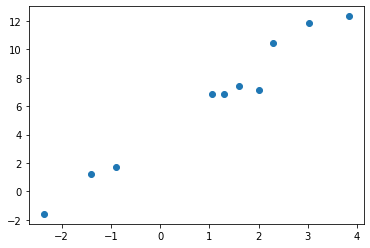

In [97]:
plt.scatter(x,y)

Now the fun(trouble) begins!

So we assume the prior here to be a weibull distribution. It has parameters $λ,k$ which signify scale and shape respectively.

The distribution is very dangerous. So lets just see the pdf (which we need) and move on.

\begin{equation}
    f(x;λ,k)=
    \begin{cases}
      \frac{k}{λ}\left(\frac{x}{λ}\right)^ke^{-(x/λ)^k}&,  \text{if}\ x\ge1 \\
      0 &,  \text{if}\ x<0
    \end{cases}
\end{equation}

Lets now look at how pdf varies if we vary the parameters of the funtion.

In [148]:
 
alpha = 10
beta = 15
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc = (theta+jnp.array([[10,5]]).T).reshape(theta.shape[0],),scale=10*jnp.identity(theta.shape[0])
)

print(prior_normal.prob((theta.reshape(2,))))

3.072411e-05


In [135]:

# lamda = 10.0  --- This was giving some problems. Anyways
y = y.reshape(y.shape[0],)
def log_postfn(theta):
  # from the above equation
  # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
  log_prior = prior_normal.log_prob(theta)
  # log_likelihood
  mean = (x_trans@theta.reshape(theta.shape[0],1)).reshape(y.shape[0],)
  likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(y.shape[0]))
  log_like = jnp.array(likelihood_normal.log_prob(y))
  return (log_like+log_prior)

log_postfn((theta+jnp.array([[6.4,9.1]]).T).reshape(theta.shape[0],))


DeviceArray(-2760.939, dtype=float32)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [143]:
rmh = blackjax.rmh(log_postfn, sigma=jnp.identity(theta.shape[0]) * 0.7)
m = jnp.array((theta+jnp.array([[6.4,9.1]]).T).reshape(theta.shape[0],))
initial_state = rmh.init(m)
initial_state

RMHState(position=DeviceArray([10.4     , 11.400001], dtype=float32), log_probability=DeviceArray(-2760.939, dtype=float32))

I don't have a good idea of how the below fn works but it will give us the samples that we need.

In [144]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Lets generate samples from posterior distribution now.

In [145]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

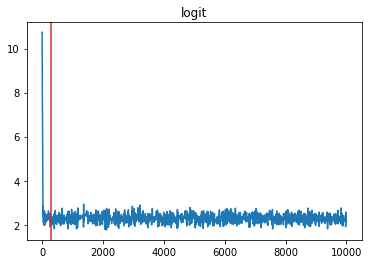

In [147]:
burnin = 300
fig, ax = plt.subplots()
ax.plot(states.position[:,1])
ax.set_title(f"logit")
ax.axvline(x=burnin, c="tab:red")
plt.show()

In [108]:
jnp.sum(samples==1)
one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')

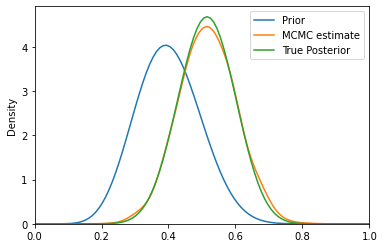

In [109]:
import seaborn as sns
# plt.hist(jax.nn.sigmoid(states.position[300:,0]),density=True,bins=20)
beta_dist = tfd.Beta(alpha,beta)
x = jnp.linspace(0,1,100)
beta_pdf = beta_dist.prob(x)
plt.plot(x,beta_pdf,label="Prior")
sns.kdeplot(jax.nn.sigmoid(states.position[300:,0]),bw_adjust=2,label="MCMC estimate")
beta_dist = tfd.Beta(alpha+one,beta+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")
plt.legend()
plt.xlim(0,1)
plt.show()

In [112]:
 
alpha = 10
beta = 15
beta_dist = tfd.Beta(alpha,beta)
@widgets.interact(alpha=(0,20,0.2),beta=(0,20,0.2))
def plot_weibull(alpha=18,beta=17):
  beta_dist = tfd.Beta(alpha,beta)
  x = jnp.linspace(0,1,100)
  beta_pdf = beta_dist.prob(x)
  plt.plot(x,beta_pdf)
  plt.title('Posterior PDF')
  plt.xlim(0,1)
  plt.ylim(0,5)
  # plt.show()

interactive(children=(FloatSlider(value=18.0, description='alpha', max=20.0, step=0.2), FloatSlider(value=17.0…

In [149]:
import pickle

In [150]:
di = {"data":{"x":x,"y":y},
              "noise_variance":1,
              "prior":{
                    "mean":(theta+jnp.array([[10,5]]).T).reshape(theta.shape[0],),
                    "var":10*jnp.identity(theta.shape[0])}}

with open('linear regression normal distribution','wb') as f:
    pickle.dump(di,f)

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>